### Importing all libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#### Importing train data and converting string-date columns into datetime format

In [3]:
train_df=pd.read_csv('train.csv')
train_df['MMM-YY']=pd.to_datetime(train_df['MMM-YY'],errors='coerce')
train_df['LastWorkingDate']=pd.to_datetime(train_df['LastWorkingDate'],errors='coerce')
train_df['Dateofjoining']=pd.to_datetime(train_df['Dateofjoining'],errors='coerce')
train_df.rename(columns={'MMM-YY':'Month_Reporting_Date'},inplace=True)
train_df.head()

,Month_Reporting_Date,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaT,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaT,2,2,0,1


### Creation of Attrition Flag

#### How to understand if employee has attrited or not ?
Lets check if the last working day is present or not if yes then he has attrited otherwise not

In [4]:
train_df['Attrition_Flag']=0
train_df.loc[pd.isna(train_df['LastWorkingDate'])==False,'Attrition_Flag']=1

#### No missing values in the useful data !

In [5]:
train_df.isna().sum()

Month_Reporting_Date        0
Emp_ID                      0
Age                         0
Gender                      0
City                        0
Education_Level             0
Salary                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Designation                 0
Total Business Value        0
Quarterly Rating            0
Attrition_Flag              0
dtype: int64

In [6]:
train_df['Attrition_Flag'].value_counts()

0    17488
1     1616
Name: Attrition_Flag, dtype: int64

#### data is reported at monthly level need to bring it to unique level at employee level.

In [7]:
unique_id=train_df.groupby('Emp_ID',as_index=False)['Attrition_Flag'].max()
unique_id.head()

,Emp_ID,Attrition_Flag
0,1,1
1,2,0
2,4,1
3,5,1
4,6,0


In [8]:
unique_id.shape

(2381, 2)

#### following function will calculate if employee has changed/ updated any of the details (in terms of parameters for eg is there any education level update or not ?)  

In [9]:
def change_in_details(col):
    return [1 if len(train_df[train_df['Emp_ID']==i][col].unique())>1 else 0 for i in unique_id['Emp_ID']]    

In [10]:
unique_id['Change in City']=change_in_details(col='City')

unique_id['Change in Designation']=change_in_details(col='Designation')

#### We can see there is no change in city by any employee who has left or who is in the organization

In [11]:
unique_id['Change in City'].value_counts()

0    2381
Name: Change in City, dtype: int64

We can calculate what is kind of designation change or promotion an employee is getting over the time frame. 

In [12]:
unique_id['Promotion level']=[train_df[train_df['Emp_ID']==i]['Designation'].min()-train_df[train_df['Emp_ID']==i]['Joining Designation'].max() if (unique_id[unique_id['Emp_ID']==i]['Change in Designation'].max()==1) else 0 for i in unique_id['Emp_ID']]

 Its important to understand what is change in monthly salary if the employees have undergone any promotion.

In [13]:
unique_id['Change in Salary']=change_in_details(col='Salary')
unique_id['Max_change_in_Salary']= [train_df[train_df['Emp_ID']==i]['Salary'].max()-train_df[train_df['Emp_ID']==i]['Salary'].min() if (unique_id[unique_id['Emp_ID']==i]['Change in Salary'].max()==1) else 0 for i in unique_id['Emp_ID']]

In [14]:
unique_id['Attrition_Flag']=[1 if train_df[train_df['Emp_ID']==i]['Attrition_Flag'].max()==1 else 0 for i in unique_id['Emp_ID']] 
unique_id['Attrition_Flag'].value_counts(normalize=True)*100

1    67.870643
0    32.129357
Name: Attrition_Flag, dtype: float64

Creating variables :- tenure of employee in years , months and days

In [15]:
unique_id['tenure_in_years']=[round((train_df[train_df['Emp_ID']==i]['LastWorkingDate'].max()-train_df[train_df['Emp_ID']==i]['Dateofjoining'].min()).days/365.25,0)
if ((train_df[train_df['Emp_ID']==i]['LastWorkingDate'].isna().values.all()))==False
                              else round((train_df[train_df['Emp_ID']==i]['Month_Reporting_Date'].max()-train_df[train_df['Emp_ID']==i]['Dateofjoining'].min()).days/365.25,0) for i in unique_id['Emp_ID']]


unique_id['tenure_in_months']=[round((train_df[train_df['Emp_ID']==i]['LastWorkingDate'].max()-train_df[train_df['Emp_ID']==i]['Dateofjoining'].min()).days/30,0)
if ((train_df[train_df['Emp_ID']==i]['LastWorkingDate'].isna().values.all()))==False
                              else round((train_df[train_df['Emp_ID']==i]['Month_Reporting_Date'].max()-train_df[train_df['Emp_ID']==i]['Dateofjoining'].min()).days/30,0) for i in unique_id['Emp_ID']]


unique_id['tenure_in_days']=[round((train_df[train_df['Emp_ID']==i]['LastWorkingDate'].max()-train_df[train_df['Emp_ID']==i]['Dateofjoining'].min()).days,0)
if ((train_df[train_df['Emp_ID']==i]['LastWorkingDate'].isna().values.all()))==False
                              else round((train_df[train_df['Emp_ID']==i]['Month_Reporting_Date'].max()-train_df[train_df['Emp_ID']==i]['Dateofjoining'].min()).days,0) for i in unique_id['Emp_ID']]


In [16]:
df1=unique_id.merge(train_df.groupby('Emp_ID',as_index=False)['Salary'].mean().rename({'Salary':'Average Monthly Salary'},axis=1),how='left',on='Emp_ID')

In [17]:
df1.head()

,Emp_ID,Attrition_Flag,Change in City,Change in Designation,Promotion level,Change in Salary,Max_change_in_Salary,tenure_in_years,tenure_in_months,tenure_in_days,Average Monthly Salary
0,1,1,0,0,0,0,0,0.0,3.0,78,57387.0
1,2,0,0,0,0,0,0,0.0,1.0,25,67016.0
2,4,1,0,0,0,0,0,0.0,5.0,141,65603.0
3,5,1,0,0,0,0,0,0.0,2.0,58,46368.0
4,6,0,0,0,0,0,0,0.0,4.0,123,78728.0


Here we can see all the people who had left were getting less average monthly salary. This might be the issue attributing attrition

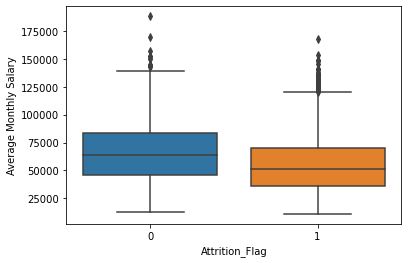

In [18]:
sns.boxplot(df1['Attrition_Flag'],df1['Average Monthly Salary'])

###### We can see the clear cut difference between Attrited and Non-Attrited people. Attrited are having less average monthly salary 

In [19]:
df1['tenure_in_years'].mode()

0    0.0
dtype: float64

Now we will look at the outliers in Average Monthly Salary
Will be using capping and flooring method.

In [20]:
percentiles = df1['Average Monthly Salary'].quantile([0.05, 0.95]).values
df1['Average Monthly Salary']=np.clip(df1['Average Monthly Salary'], percentiles[0], percentiles[1])

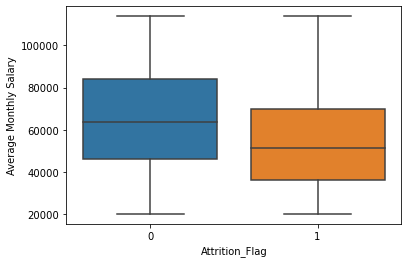

In [21]:
sns.boxplot(df1['Attrition_Flag'],df1['Average Monthly Salary'])

In [22]:
ed=pd.DataFrame(train_df.groupby(['Emp_ID'])['Education_Level'].apply(pd.Series.mode)).reset_index()
ed.drop(['level_1'],axis=1,inplace=True)
### Education Level
df2=df1.merge(ed,how='left',on='Emp_ID')
df2.head()

,Emp_ID,Attrition_Flag,Change in City,Change in Designation,Promotion level,Change in Salary,Max_change_in_Salary,tenure_in_years,tenure_in_months,tenure_in_days,Average Monthly Salary,Education_Level
0,1,1,0,0,0,0,0,0.0,3.0,78,57387.0,Master
1,2,0,0,0,0,0,0,0.0,1.0,25,67016.0,Master
2,4,1,0,0,0,0,0,0.0,5.0,141,65603.0,Master
3,5,1,0,0,0,0,0,0.0,2.0,58,46368.0,College
4,6,0,0,0,0,0,0,0.0,4.0,123,78728.0,Bachelor


C:\Users\Tushar\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Education_Level  Attrition_Flag
Bachelor         0                 64997.5
                 1                 52011.0
College          0                 56430.5
                 1                 47177.0
Master           0                 67326.0
                 1                 54632.0
Name: Average Monthly Salary, dtype: float64


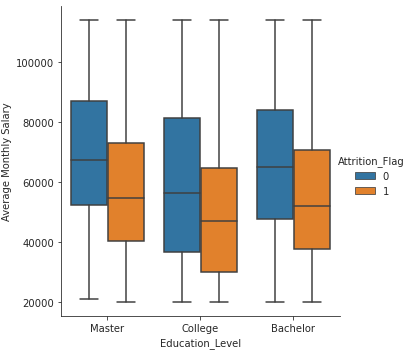

In [23]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("Education_Level", "Average Monthly Salary", "Attrition_Flag", data=df2, kind="box")
    g.set_axis_labels("Education_Level", "Average Monthly Salary");
    
print(df2.groupby(['Education_Level','Attrition_Flag'])['Average Monthly Salary'].median())

We can see especially in case of people with only Bachelors are tending to attrite more.

In [24]:
df2['Salary_Attritor_Flag']=np.where(df2['Average Monthly Salary']<df2[df2['Attrition_Flag']==1]['Average Monthly Salary'].mean(),1,0)
df2['Bachelor_Salary_Attritor_Flag']=np.where(df2['Average Monthly Salary']<df2[(df2['Attrition_Flag']==1) & (df2['Education_Level']=='Bachelor')]['Average Monthly Salary'].mean(),1,0)
df2['Bachelor_tenure_Attritor_Flag']=np.where((df2['tenure_in_days']>170) & (df2['tenure_in_days']<190) & (df2['Education_Level']=='Bachelor'),1,0)

C:\Users\Tushar\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Education_Level  Attrition_Flag
Bachelor         0                 280.5
                 1                 180.0
College          0                 164.0
                 1                 169.0
Master           0                 184.0
                 1                 182.0
Name: tenure_in_days, dtype: float64


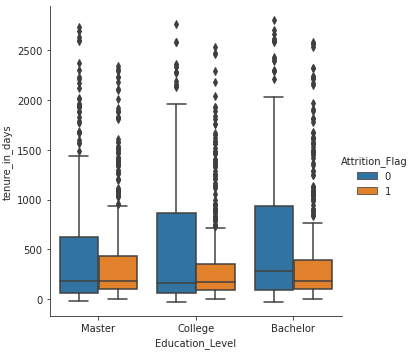

In [25]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("Education_Level", "tenure_in_days", "Attrition_Flag", data=df2, kind="box")
    g.set_axis_labels("Education_Level", "tenure_in_days");
    
print(df2.groupby(['Education_Level','Attrition_Flag'])['tenure_in_days'].median())

Again same difference is being observed People with Bachelors degree are staying for less number of days in company compared to those havent attrited.

In [26]:
df2.head()

,Emp_ID,Attrition_Flag,Change in City,Change in Designation,Promotion level,Change in Salary,Max_change_in_Salary,tenure_in_years,tenure_in_months,tenure_in_days,Average Monthly Salary,Education_Level,Salary_Attritor_Flag,Bachelor_Salary_Attritor_Flag,Bachelor_tenure_Attritor_Flag
0,1,1,0,0,0,0,0,0.0,3.0,78,57387.0,Master,0,0,0
1,2,0,0,0,0,0,0,0.0,1.0,25,67016.0,Master,0,0,0
2,4,1,0,0,0,0,0,0.0,5.0,141,65603.0,Master,0,0,0
3,5,1,0,0,0,0,0,0.0,2.0,58,46368.0,College,1,1,0
4,6,0,0,0,0,0,0,0.0,4.0,123,78728.0,Bachelor,0,0,0


In [27]:
ed=pd.DataFrame(train_df.groupby(['Emp_ID'])['Gender'].apply(pd.Series.mode)).reset_index()
ed.drop(['level_1'],axis=1,inplace=True)
### Education Level
ed1=pd.DataFrame(train_df.groupby(['Emp_ID'])['City'].apply(pd.Series.mode)).reset_index()
ed1.drop(['level_1'],axis=1,inplace=True)
#####
ed2=pd.DataFrame(train_df.groupby(['Emp_ID'],as_index=False)[['Joining Designation','Designation']].max())
#####

Trying to see which is maximum rating and minimum rating employee has recieved in his tenure.

In [28]:
grouped = train_df.groupby('Emp_ID',as_index=False)['Quarterly Rating'].agg(['mean','max','min'])

grouped.reset_index(inplace=True)
grouped.rename({'mean':'Avergae_Rating','max':'Max_Rating','min':'Min_Rating'},axis=1,inplace=True)
grouped
#df.groupby('dummy').agg({'returns':{'Mean': np.mean, 'Sum': np.sum}})

,Emp_ID,Avergae_Rating,Max_Rating,Min_Rating
0,1,2.000000,2,2
1,2,1.000000,1,1
2,4,1.000000,1,1
3,5,1.000000,1,1
4,6,1.600000,2,1
...,...,...,...,...
2376,2784,2.625000,4,1
2377,2785,1.000000,1,1
2378,2786,1.666667,2,1
2379,2787,1.500000,2,1


In [29]:
df3=df2.merge(ed,how='left',on='Emp_ID').merge(ed1,how='left',on='Emp_ID').merge(ed2,how='left',on='Emp_ID').merge(grouped,how='left',on='Emp_ID').merge(train_df.groupby('Emp_ID',as_index=False)['Age'].max(),how='left',on='Emp_ID')
df3.head()

,Emp_ID,Attrition_Flag,Change in City,Change in Designation,Promotion level,Change in Salary,Max_change_in_Salary,tenure_in_years,tenure_in_months,tenure_in_days,...,Bachelor_Salary_Attritor_Flag,Bachelor_tenure_Attritor_Flag,Gender,City,Joining Designation,Designation,Avergae_Rating,Max_Rating,Min_Rating,Age
0,1,1,0,0,0,0,0,0.0,3.0,78,...,0,0,Male,C23,1,1,2.0,2,2,28
1,2,0,0,0,0,0,0,0.0,1.0,25,...,0,0,Male,C7,2,2,1.0,1,1,31
2,4,1,0,0,0,0,0,0.0,5.0,141,...,0,0,Male,C13,2,2,1.0,1,1,43
3,5,1,0,0,0,0,0,0.0,2.0,58,...,1,0,Male,C9,1,1,1.0,1,1,29
4,6,0,0,0,0,0,0,0.0,4.0,123,...,0,0,Female,C11,3,3,1.6,2,1,31


In [30]:
df3['Positive_Business_Proportion']=[train_df[(train_df['Emp_ID']==i) & (train_df['Total Business Value']>0)].shape[0]/ (train_df[(train_df['Emp_ID']==i) & (train_df['Total Business Value']>0)].shape[0]+train_df[(train_df['Emp_ID']==i) & (train_df['Total Business Value']<=0)].shape[0]) for i in df3.Emp_ID]
df3['Max_Positive_Business']=[train_df[(train_df['Emp_ID']==i)]['Total Business Value'].max() for i in df3.Emp_ID]
df3['Min_Business']=[train_df[(train_df['Emp_ID']==i)]['Total Business Value'].min() for i in df3.Emp_ID]
df3['Average_Business_value']=[train_df[(train_df['Emp_ID']==i)]['Total Business Value'].mean() for i in df3.Emp_ID]
df3['Total_Business_value']=[train_df[(train_df['Emp_ID']==i)]['Total Business Value'].sum() for i in df3.Emp_ID]

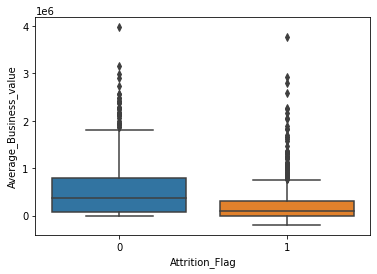

In [31]:
sns.boxplot(x='Attrition_Flag',y='Average_Business_value',data=df3)

In [32]:
percentiles = df3['Average_Business_value'].quantile([0.05, 0.95]).values
df3['Average_Business_value']=np.clip(df3['Average_Business_value'], percentiles[0], percentiles[1])

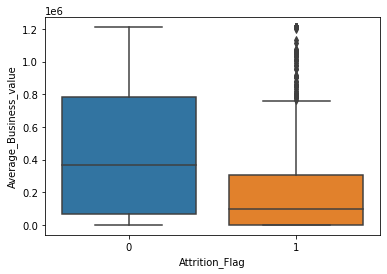

In [33]:
sns.boxplot(x='Attrition_Flag',y='Average_Business_value',data=df3)

In [34]:
df3['Business_value_Attrition_Flag']=np.where(df3['Average_Business_value']<df3[df3['Attrition_Flag']==1]['Average_Business_value'].median(),1,0)

In [35]:
df3.groupby(['Business_value_Attrition_Flag'])['Attrition_Flag'].mean()

Business_value_Attrition_Flag
0    0.599407
1    0.782188
Name: Attrition_Flag, dtype: float64

In [36]:
df3.head()

,Emp_ID,Attrition_Flag,Change in City,Change in Designation,Promotion level,Change in Salary,Max_change_in_Salary,tenure_in_years,tenure_in_months,tenure_in_days,...,Avergae_Rating,Max_Rating,Min_Rating,Age,Positive_Business_Proportion,Max_Positive_Business,Min_Business,Average_Business_value,Total_Business_value,Business_value_Attrition_Flag
0,1,1,0,0,0,0,0,0.0,3.0,78,...,2.0,2,2,28,0.333333,2381060,-665480,571860.0,1715580,0
1,2,0,0,0,0,0,0,0.0,1.0,25,...,1.0,1,1,31,0.000000,0,0,0.0,0,1
2,4,1,0,0,0,0,0,0.0,5.0,141,...,1.0,1,1,43,0.200000,350000,0,70000.0,350000,1
3,5,1,0,0,0,0,0,0.0,2.0,58,...,1.0,1,1,29,0.333333,120360,0,40120.0,120360,1
4,6,0,0,0,0,0,0,0.0,4.0,123,...,1.6,2,1,31,0.200000,1265000,0,253000.0,1265000,0


Text(0.5, 1.0, 'Age- Density plot')

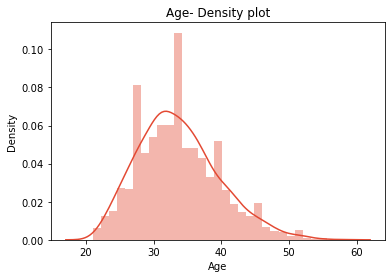

In [37]:
### Age wise distribution
sns.set_palette("RdYlBu")
sns.distplot(df3['Age'])
plt.ylabel('Density')
plt.title('Age- Density plot')

In [38]:
df3['Age_bins']=pd.qcut(df3['Age'],q=4)
t1=pd.DataFrame(df3.groupby('Age_bins',as_index=False)['Attrition_Flag'].mean())
t1.head()

,Age_bins,Attrition_Flag
0,"(20.999, 29.0]",0.729951
1,"(29.0, 33.0]",0.704688
2,"(33.0, 37.0]",0.620321
3,"(37.0, 58.0]",0.652021


In [39]:
df3.head()

,Emp_ID,Attrition_Flag,Change in City,Change in Designation,Promotion level,Change in Salary,Max_change_in_Salary,tenure_in_years,tenure_in_months,tenure_in_days,...,Max_Rating,Min_Rating,Age,Positive_Business_Proportion,Max_Positive_Business,Min_Business,Average_Business_value,Total_Business_value,Business_value_Attrition_Flag,Age_bins
0,1,1,0,0,0,0,0,0.0,3.0,78,...,2,2,28,0.333333,2381060,-665480,571860.0,1715580,0,"(20.999, 29.0]"
1,2,0,0,0,0,0,0,0.0,1.0,25,...,1,1,31,0.000000,0,0,0.0,0,1,"(29.0, 33.0]"
2,4,1,0,0,0,0,0,0.0,5.0,141,...,1,1,43,0.200000,350000,0,70000.0,350000,1,"(37.0, 58.0]"
3,5,1,0,0,0,0,0,0.0,2.0,58,...,1,1,29,0.333333,120360,0,40120.0,120360,1,"(20.999, 29.0]"
4,6,0,0,0,0,0,0,0.0,4.0,123,...,2,1,31,0.200000,1265000,0,253000.0,1265000,0,"(29.0, 33.0]"


In [40]:
train_df.groupby('Emp_ID')['Education_Level'].nunique().loc[lambda x:x>1]

Series([], Name: Education_Level, dtype: int64)

#### Above query was written to check if after joining any employee has upgraded education status or not  but  

####  I could see no employee has updated the education so change in Education level doesnt seems to be working

In [41]:
df3.columns

Index(['Emp_ID', 'Attrition_Flag', 'Change in City', 'Change in Designation',
       'Promotion level', 'Change in Salary', 'Max_change_in_Salary',
       'tenure_in_years', 'tenure_in_months', 'tenure_in_days',
       'Average Monthly Salary', 'Education_Level', 'Salary_Attritor_Flag',
       'Bachelor_Salary_Attritor_Flag', 'Bachelor_tenure_Attritor_Flag',
       'Gender', 'City', 'Joining Designation', 'Designation',
       'Avergae_Rating', 'Max_Rating', 'Min_Rating', 'Age',
       'Positive_Business_Proportion', 'Max_Positive_Business', 'Min_Business',
       'Average_Business_value', 'Total_Business_value',
       'Business_value_Attrition_Flag', 'Age_bins'],
      dtype='object')

In [42]:
df3['Promotion level'].value_counts()

0    2356
1      16
2       8
3       1
Name: Promotion level, dtype: int64

In [43]:
df3.rename({'Change in Salary':'Change in Salary Flag','Change in City':'Change in City Flag'},inplace=True,axis=1)

In [296]:
df4=pd.get_dummies(df3,columns={'Joining Designation', 'Designation','Education_Level','City','Gender'},drop_first=True)

In [297]:
df4.drop(['Emp_ID','Age_bins'],axis=1,inplace=True)

In [298]:
from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(df4)

VarianceThreshold(threshold=0)

In [299]:
constant_columns = [column for column in df4.columns
                    if column not in df4.columns[var_thres.get_support()]]

print(len(constant_columns))
df4.drop(constant_columns,axis=1)

1


,Attrition_Flag,Change in Designation,Promotion level,Change in Salary Flag,Max_change_in_Salary,tenure_in_years,tenure_in_months,tenure_in_days,Average Monthly Salary,Salary_Attritor_Flag,...,Education_Level_Master,Gender_Male,Joining Designation_2,Joining Designation_3,Joining Designation_4,Joining Designation_5,Designation_2,Designation_3,Designation_4,Designation_5
0,1,0,0,0,0,0.0,3.0,78,57387.0,0,...,1,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0.0,1.0,25,67016.0,0,...,1,1,1,0,0,0,1,0,0,0
2,1,0,0,0,0,0.0,5.0,141,65603.0,0,...,1,1,1,0,0,0,1,0,0,0
3,1,0,0,0,0,0.0,2.0,58,46368.0,1,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0.0,4.0,123,78728.0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,0,0,0,0,0,5.0,62.0,1873,82815.0,0,...,0,1,1,0,0,0,0,1,0,0
2377,1,0,0,0,0,0.0,2.0,61,20170.0,1,...,0,0,0,0,0,0,0,0,0,0
2378,1,0,0,0,0,1.0,14.0,419,35370.0,1,...,0,1,1,0,0,0,1,0,0,0
2379,1,0,0,0,0,1.0,11.0,335,69498.0,0,...,1,0,0,0,0,0,0,0,0,0


In [300]:
X=df4.drop(['Attrition_Flag'],axis=1)
y=df4['Attrition_Flag']

In [301]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

X_train.shape, X_test.shape

((1904, 61), (477, 61))

In [302]:
X_train=pd.concat([X_train,y_train],axis=1)
X_test=pd.concat([X_test,y_test],axis=1)

In [303]:
def remove_corr_var(train=X_train,test=X_test,target_threshold = 10**-3,within_threshold=0.95):
    initial_feature = train.shape[1]
    corr = train.corr().abs()
    corr_target = pd.DataFrame(corr['Attrition_Flag']).sort_values(by='Attrition_Flag')
    threshold=target_threshold
    feat_df =corr_target[(corr_target['Attrition_Flag'])<=threshold]
    print("There are %i features that have a correlation values less than %.3f with 'TARGET'. We will remove all of this."\
        %(feat_df.shape[0],threshold))
    print("Removing.........")
    for df in [train,test]:
        df.drop(feat_df.index,axis=1,inplace=True)
    #removing highly correlated features(keeping one)
    #https://www.dezyre.com/recipes/drop-out-highly-correlated-features-in-python
    corr.drop('Attrition_Flag',axis=1,inplace=True)
    corr.drop('Attrition_Flag',axis=0,inplace=True)
    corr.drop(feat_df.index,axis=1,inplace=True)
    corr.drop(feat_df.index,inplace=True)
    threshold = within_threshold
    upper = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool)) #getting upper traingle of correlation matrix
    column = [col for col in upper.columns if any(upper[col]>threshold)] #getting all columns that have high correlation with one of the features
    print("There are %i features that have high correlation with another feature with threshold being kept as %.3f and above. We will remove all of this."\
        %(len(column),threshold))
    print("Removing.........")
    for df in [train,test]:
        df.drop(column,axis=1,inplace=True)
    print("The features were changed from %i to %i. %i features were removed."%(initial_feature,train.shape[1],initial_feature-train.shape[1]))
remove_corr_var(train=X_train,test=X_test,target_threshold = 10**-3,within_threshold=0.85)

There are 0 features that have a correlation values less than 0.001 with 'TARGET'. We will remove all of this.
Removing.........
There are 8 features that have high correlation with another feature with threshold being kept as 0.850 and above. We will remove all of this.
Removing.........
The features were changed from 62 to 54. 8 features were removed.


In [304]:
X_train.drop(['Attrition_Flag'],axis=1,inplace=True)
X_test.drop(['Attrition_Flag'],axis=1,inplace=True)

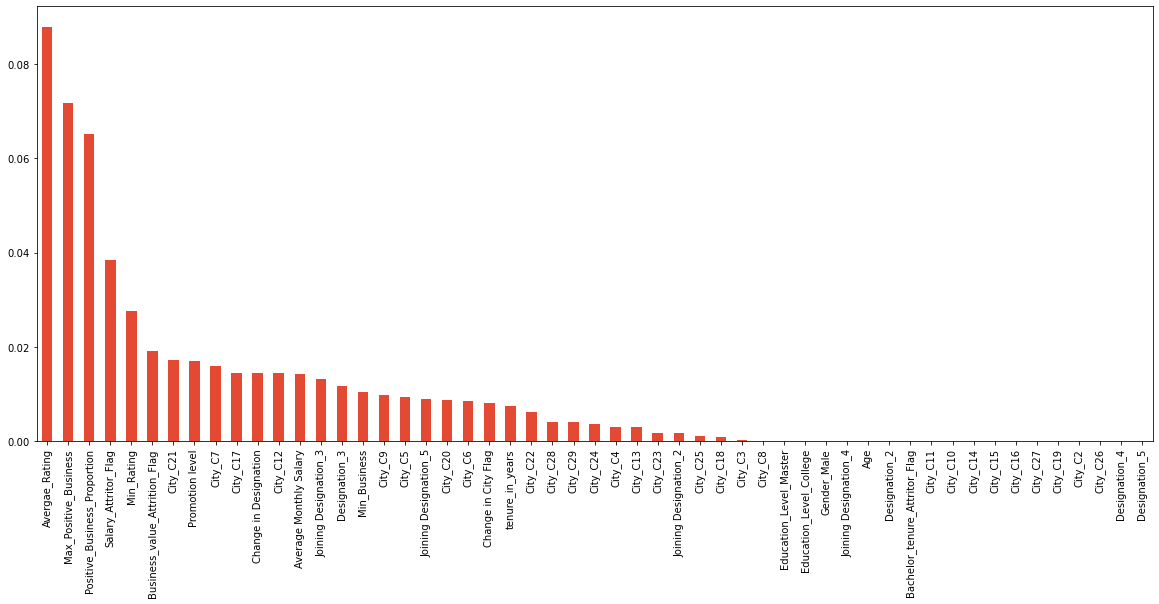

In [305]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

mi = mutual_info_classif(X_train.fillna(0), y_train)
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False)
# and now let's plot the ordered MI values per feature
mi.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [308]:
mi.index

Index(['Change in City Flag', 'Change in Designation', 'Promotion level',
       'tenure_in_years', 'Average Monthly Salary', 'Salary_Attritor_Flag',
       'Bachelor_tenure_Attritor_Flag', 'Avergae_Rating', 'Min_Rating', 'Age',
       'Positive_Business_Proportion', 'Max_Positive_Business', 'Min_Business',
       'Business_value_Attrition_Flag', 'City_C10', 'City_C11', 'City_C12',
       'City_C13', 'City_C14', 'City_C15', 'City_C16', 'City_C17', 'City_C18',
       'City_C19', 'City_C2', 'City_C20', 'City_C21', 'City_C22', 'City_C23',
       'City_C24', 'City_C25', 'City_C26', 'City_C27', 'City_C28', 'City_C29',
       'City_C3', 'City_C4', 'City_C5', 'City_C6', 'City_C7', 'City_C8',
       'City_C9', 'Education_Level_College', 'Education_Level_Master',
       'Gender_Male', 'Joining Designation_2', 'Joining Designation_3',
       'Joining Designation_4', 'Joining Designation_5', 'Designation_2',
       'Designation_3', 'Designation_4', 'Designation_5'],
      dtype='object')

In [309]:
final_features=mi.index[mi.values>0.02].tolist()
X_train_final=X_train[final_features]
X_test_final=X_test[final_features]

In [310]:
X_train_final.columns.tolist()

['Salary_Attritor_Flag',
 'Avergae_Rating',
 'Min_Rating',
 'Positive_Business_Proportion',
 'Max_Positive_Business']

In [ ]:
### Feature_selection by RFE

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

sel_ = RFE(RandomForestClassifier(n_estimators=500,class_weight='balanced'), n_features_to_select=10)
sel_.fit(X_train.fillna(0), y_train)

RFE(estimator=RandomForestClassifier(class_weight='balanced', n_estimators=500),
    n_features_to_select=10)

In [57]:
# let's add the variable names and order it for clearer visualisation
selected_feat = X_train.columns[(sel_.get_support())]
selected_feat

Index(['tenure_in_years', 'Average Monthly Salary', 'Avergae_Rating',
       'Min_Rating', 'Age', 'Positive_Business_Proportion',
       'Max_Positive_Business', 'Education_Level_College', 'Gender_Male',
       'Joining Designation_3'],
      dtype='object')

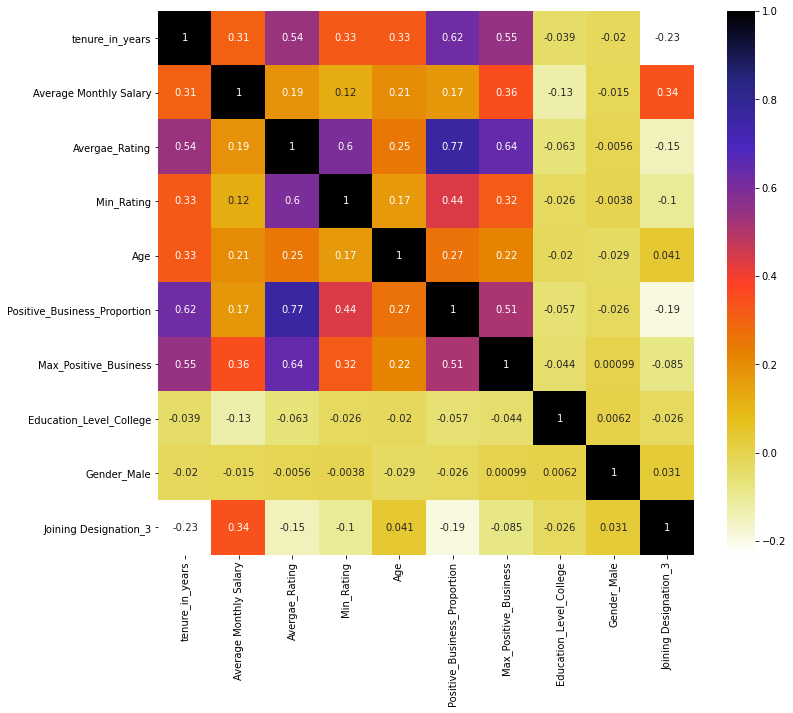

In [58]:
X_train_final=X_train[selected_feat]
X_test_final=X_test[selected_feat]

import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = X_train_final.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [311]:
from sklearn.feature_selection import SelectFromModel
from catboost import CatBoostClassifier
selector = SelectFromModel(estimator=CatBoostClassifier(auto_class_weights='Balanced',verbose=True)).fit(X_train, y_train)

Learning rate set to 0.013563
0:	learn: 0.6897108	total: 120ms	remaining: 1m 59s
1:	learn: 0.6853037	total: 125ms	remaining: 1m 2s
2:	learn: 0.6822880	total: 130ms	remaining: 43.3s
3:	learn: 0.6784611	total: 135ms	remaining: 33.6s
4:	learn: 0.6749361	total: 140ms	remaining: 27.9s
5:	learn: 0.6726908	total: 145ms	remaining: 24.1s
6:	learn: 0.6693339	total: 150ms	remaining: 21.3s
7:	learn: 0.6665621	total: 155ms	remaining: 19.2s
8:	learn: 0.6640079	total: 160ms	remaining: 17.6s
9:	learn: 0.6613687	total: 165ms	remaining: 16.4s
10:	learn: 0.6581292	total: 170ms	remaining: 15.3s
11:	learn: 0.6555719	total: 175ms	remaining: 14.4s
12:	learn: 0.6522418	total: 180ms	remaining: 13.7s
13:	learn: 0.6497230	total: 187ms	remaining: 13.1s
14:	learn: 0.6467329	total: 192ms	remaining: 12.6s
15:	learn: 0.6440109	total: 197ms	remaining: 12.1s
16:	learn: 0.6414071	total: 203ms	remaining: 11.7s
17:	learn: 0.6384713	total: 209ms	remaining: 11.4s
18:	learn: 0.6363193	total: 214ms	remaining: 11.1s
19:	learn:

185:	learn: 0.5072994	total: 1.23s	remaining: 5.4s
186:	learn: 0.5069451	total: 1.24s	remaining: 5.39s
187:	learn: 0.5067898	total: 1.24s	remaining: 5.38s
188:	learn: 0.5064799	total: 1.25s	remaining: 5.36s
189:	learn: 0.5061180	total: 1.25s	remaining: 5.35s
190:	learn: 0.5059108	total: 1.26s	remaining: 5.34s
191:	learn: 0.5056771	total: 1.26s	remaining: 5.33s
192:	learn: 0.5054976	total: 1.27s	remaining: 5.31s
193:	learn: 0.5049811	total: 1.27s	remaining: 5.3s
194:	learn: 0.5045561	total: 1.28s	remaining: 5.28s
195:	learn: 0.5042352	total: 1.28s	remaining: 5.27s
196:	learn: 0.5039576	total: 1.29s	remaining: 5.25s
197:	learn: 0.5036730	total: 1.29s	remaining: 5.24s
198:	learn: 0.5033633	total: 1.3s	remaining: 5.22s
199:	learn: 0.5031019	total: 1.3s	remaining: 5.21s
200:	learn: 0.5027309	total: 1.31s	remaining: 5.19s
201:	learn: 0.5025165	total: 1.31s	remaining: 5.18s
202:	learn: 0.5022918	total: 1.31s	remaining: 5.17s
203:	learn: 0.5020525	total: 1.32s	remaining: 5.15s
204:	learn: 0.50

360:	learn: 0.4682609	total: 2.07s	remaining: 3.66s
361:	learn: 0.4682542	total: 2.07s	remaining: 3.65s
362:	learn: 0.4680906	total: 2.08s	remaining: 3.65s
363:	learn: 0.4679661	total: 2.08s	remaining: 3.64s
364:	learn: 0.4678847	total: 2.09s	remaining: 3.63s
365:	learn: 0.4676901	total: 2.09s	remaining: 3.63s
366:	learn: 0.4675648	total: 2.1s	remaining: 3.62s
367:	learn: 0.4674140	total: 2.1s	remaining: 3.61s
368:	learn: 0.4672459	total: 2.11s	remaining: 3.61s
369:	learn: 0.4671979	total: 2.11s	remaining: 3.6s
370:	learn: 0.4669581	total: 2.12s	remaining: 3.59s
371:	learn: 0.4667135	total: 2.12s	remaining: 3.58s
372:	learn: 0.4665080	total: 2.13s	remaining: 3.57s
373:	learn: 0.4662604	total: 2.13s	remaining: 3.57s
374:	learn: 0.4660789	total: 2.13s	remaining: 3.56s
375:	learn: 0.4658880	total: 2.14s	remaining: 3.55s
376:	learn: 0.4658751	total: 2.14s	remaining: 3.54s
377:	learn: 0.4658702	total: 2.15s	remaining: 3.53s
378:	learn: 0.4655754	total: 2.15s	remaining: 3.52s
379:	learn: 0.4

536:	learn: 0.4379915	total: 2.93s	remaining: 2.53s
537:	learn: 0.4378339	total: 2.94s	remaining: 2.52s
538:	learn: 0.4376592	total: 2.94s	remaining: 2.52s
539:	learn: 0.4373766	total: 2.95s	remaining: 2.51s
540:	learn: 0.4370571	total: 2.95s	remaining: 2.5s
541:	learn: 0.4369281	total: 2.96s	remaining: 2.5s
542:	learn: 0.4366346	total: 2.96s	remaining: 2.5s
543:	learn: 0.4365193	total: 2.97s	remaining: 2.49s
544:	learn: 0.4362671	total: 2.97s	remaining: 2.48s
545:	learn: 0.4361369	total: 2.98s	remaining: 2.48s
546:	learn: 0.4359705	total: 2.98s	remaining: 2.47s
547:	learn: 0.4356422	total: 2.99s	remaining: 2.46s
548:	learn: 0.4354832	total: 2.99s	remaining: 2.46s
549:	learn: 0.4353843	total: 3s	remaining: 2.45s
550:	learn: 0.4351601	total: 3s	remaining: 2.45s
551:	learn: 0.4349871	total: 3.01s	remaining: 2.44s
552:	learn: 0.4348831	total: 3.01s	remaining: 2.43s
553:	learn: 0.4345503	total: 3.02s	remaining: 2.43s
554:	learn: 0.4343996	total: 3.02s	remaining: 2.42s
555:	learn: 0.4341915

711:	learn: 0.4032633	total: 3.77s	remaining: 1.52s
712:	learn: 0.4031985	total: 3.77s	remaining: 1.52s
713:	learn: 0.4029398	total: 3.78s	remaining: 1.51s
714:	learn: 0.4027922	total: 3.79s	remaining: 1.51s
715:	learn: 0.4025456	total: 3.79s	remaining: 1.5s
716:	learn: 0.4024129	total: 3.8s	remaining: 1.5s
717:	learn: 0.4022204	total: 3.8s	remaining: 1.49s
718:	learn: 0.4019493	total: 3.81s	remaining: 1.49s
719:	learn: 0.4018239	total: 3.81s	remaining: 1.48s
720:	learn: 0.4016334	total: 3.82s	remaining: 1.48s
721:	learn: 0.4014335	total: 3.82s	remaining: 1.47s
722:	learn: 0.4011593	total: 3.83s	remaining: 1.47s
723:	learn: 0.4010123	total: 3.83s	remaining: 1.46s
724:	learn: 0.4008029	total: 3.83s	remaining: 1.45s
725:	learn: 0.4006184	total: 3.84s	remaining: 1.45s
726:	learn: 0.4004029	total: 3.84s	remaining: 1.44s
727:	learn: 0.4003039	total: 3.85s	remaining: 1.44s
728:	learn: 0.4001000	total: 3.85s	remaining: 1.43s
729:	learn: 0.3997910	total: 3.86s	remaining: 1.43s
730:	learn: 0.39

887:	learn: 0.3683941	total: 4.61s	remaining: 582ms
888:	learn: 0.3681845	total: 4.62s	remaining: 577ms
889:	learn: 0.3680079	total: 4.62s	remaining: 571ms
890:	learn: 0.3679847	total: 4.63s	remaining: 566ms
891:	learn: 0.3678784	total: 4.63s	remaining: 561ms
892:	learn: 0.3676178	total: 4.64s	remaining: 556ms
893:	learn: 0.3674096	total: 4.65s	remaining: 551ms
894:	learn: 0.3671936	total: 4.65s	remaining: 546ms
895:	learn: 0.3669946	total: 4.66s	remaining: 541ms
896:	learn: 0.3669223	total: 4.66s	remaining: 535ms
897:	learn: 0.3668742	total: 4.67s	remaining: 530ms
898:	learn: 0.3667621	total: 4.67s	remaining: 525ms
899:	learn: 0.3664941	total: 4.67s	remaining: 520ms
900:	learn: 0.3662832	total: 4.68s	remaining: 514ms
901:	learn: 0.3660918	total: 4.68s	remaining: 509ms
902:	learn: 0.3658957	total: 4.69s	remaining: 504ms
903:	learn: 0.3656833	total: 4.69s	remaining: 499ms
904:	learn: 0.3655469	total: 4.7s	remaining: 493ms
905:	learn: 0.3652779	total: 4.7s	remaining: 488ms
906:	learn: 0.

In [312]:
X_train.columns[selector.get_support()]

Index(['tenure_in_years', 'Average Monthly Salary', 'Avergae_Rating',
       'Min_Rating', 'Age', 'Positive_Business_Proportion',
       'Max_Positive_Business', 'Min_Business', 'Joining Designation_2',
       'Joining Designation_3', 'Designation_2', 'Designation_3'],
      dtype='object')

'tenure_in_years', 'Average Monthly Salary', 'Avergae_Rating',
       'Min_Rating', 'Age', 'Positive_Business_Proportion',
       'Max_Positive_Business', 'Education_Level_College', 'Gender_Male',
       'Joining Designation_3'

In [313]:
final_features_to_be_selected=['tenure_in_years', 'Average Monthly Salary', 'Avergae_Rating',
       'Min_Rating', 'Age', 'Positive_Business_Proportion',
       'Max_Positive_Business', 'Min_Business', 'Designation_2',
       'Designation_3', 'Joining Designation_2', 'Joining Designation_3','Gender_Male', 'Education_Level_College','Change in Designation']

X_train_final=X_train[final_features_to_be_selected]
X_test_final=X_test[final_features_to_be_selected]

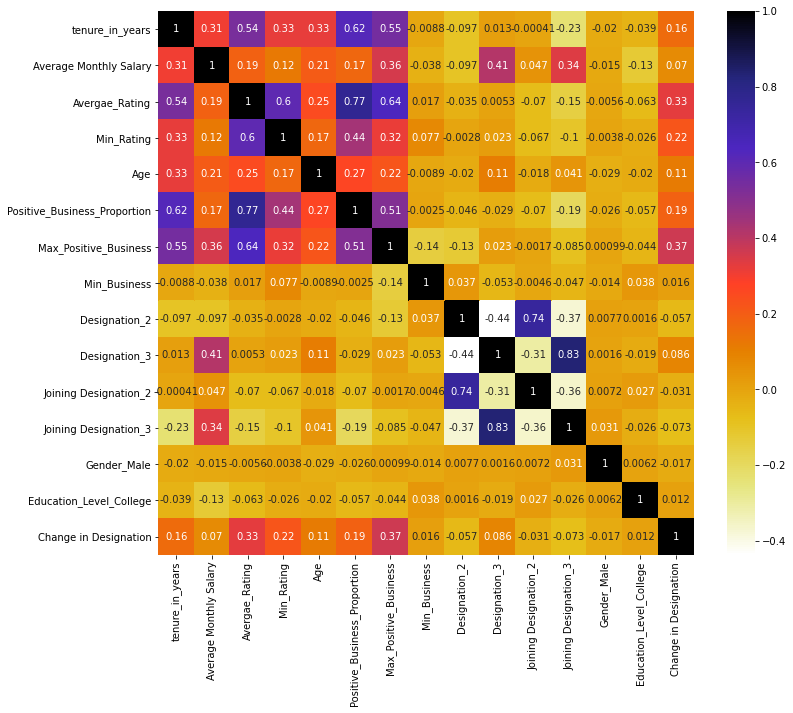

In [314]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = X_train_final.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [315]:
#### Starting with this features and building model

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import time
import sys

#metrics 
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
#### Logistic Regression

In [316]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
model=LogisticRegression(class_weight='balanced',random_state=0,C=1)
model.fit(X_train_final,y_train)
y_pred=model.predict(X_test_final)
print('Model accuracy on train data {}'.format(model.score(X_train_final,y_train)))
print('Model accuracy on test data {}'.format(model.score(X_test_final,y_test)))
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score
print(classification_report(y_test, y_pred))
print("F1 Score is {}".format(fbeta_score(y_test, y_pred, average='weighted', beta=0.5)))
print("ROC-AUC score is {}".format(roc_auc_score(y_test, y_pred)))

Model accuracy on train data 0.6391806722689075
Model accuracy on test data 0.6310272536687631
              precision    recall  f1-score   support

           0       0.43      0.48      0.45       153
           1       0.74      0.70      0.72       324

    accuracy                           0.63       477
   macro avg       0.59      0.59      0.59       477
weighted avg       0.64      0.63      0.64       477

F1 Score is 0.6388725080951091
ROC-AUC score is 0.5904139433551199


In [317]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
model=XGBClassifier(scale_pos_weight=2.1,random_state=0)
model.fit(X_train_final,y_train)
y_pred=model.predict(X_test_final)
print('Model accuracy on train data {}'.format(model.score(X_train_final,y_train)))
print('Model accuracy on test data {}'.format(model.score(X_test_final,y_test)))
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score
print(classification_report(y_test, y_pred))
print("F1 Score is {}".format(fbeta_score(y_test, y_pred, average='weighted', beta=0.5)))
print("ROC-AUC score is {}".format(roc_auc_score(y_test, y_pred)))

C:\Users\Tushar\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:15:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model accuracy on train data 0.9506302521008403
Model accuracy on test data 0.779874213836478
              precision    recall  f1-score   support

           0       0.73      0.50      0.59       153
           1       0.80      0.91      0.85       324

    accuracy                           0.78       477
   macro avg       0.76      0.71      0.72       477
weighted avg       0.77      0.78      0.77       477

F1 Score is 0.768162703257532
ROC-AUC score is 0.7068809005083515


In [318]:
## Hyper Parameter Optimization
## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 "n_estimators":[100,200,500,1000,5000]   
}

In [319]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [288]:
classifier=xgboost.XGBClassifier(scale_pos_weight=2.1,random_state=0)

from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average='weighted')
            
eval_set  = [(X_train_final, y_train), (X_test_final, y_test)]
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=10,scoring='roc_auc',n_jobs=-1,cv=10,verbose=3)

In [289]:
from datetime import datetime
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train_final,y_train,eval_set=eval_set, eval_metric='logloss',
            early_stopping_rounds=30)
timer(start_time) # timing ends here for "start_time" variable

random_search.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.5s


[0]	validation_0-logloss:0.67491	validation_1-logloss:0.67681
[1]	validation_0-logloss:0.66140	validation_1-logloss:0.66319
[2]	validation_0-logloss:0.64620	validation_1-logloss:0.64926
[3]	validation_0-logloss:0.63304	validation_1-logloss:0.63719
[4]	validation_0-logloss:0.62094	validation_1-logloss:0.62690
[5]	validation_0-logloss:0.61016	validation_1-logloss:0.61779
[6]	validation_0-logloss:0.60256	validation_1-logloss:0.61066
[7]	validation_0-logloss:0.59313	validation_1-logloss:0.60232
[8]	validation_0-logloss:0.58422	validation_1-logloss:0.59504
[9]	validation_0-logloss:0.57806	validation_1-logloss:0.58893
[10]	validation_0-logloss:0.57057	validation_1-logloss:0.58271
[11]	validation_0-logloss:0.56286	validation_1-logloss:0.57682
[12]	validation_0-logloss:0.55852	validation_1-logloss:0.57255
[13]	validation_0-logloss:0.55501	validation_1-logloss:0.56947
[14]	validation_0-logloss:0.55013	validation_1-logloss:0.56608
[15]	validation_0-logloss:0.54339	validation_1-logloss:0.55966


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.1s finished
C:\Users\Tushar\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16]	validation_0-logloss:0.53915	validation_1-logloss:0.55583
[17]	validation_0-logloss:0.53596	validation_1-logloss:0.55381
[18]	validation_0-logloss:0.53356	validation_1-logloss:0.55151
[19]	validation_0-logloss:0.53116	validation_1-logloss:0.54992
[20]	validation_0-logloss:0.52754	validation_1-logloss:0.54747
[21]	validation_0-logloss:0.52468	validation_1-logloss:0.54600
[22]	validation_0-logloss:0.52332	validation_1-logloss:0.54504
[23]	validation_0-logloss:0.51922	validation_1-logloss:0.54157
[24]	validation_0-logloss:0.51623	validation_1-logloss:0.53992
[25]	validation_0-logloss:0.51308	validation_1-logloss:0.53909
[26]	validation_0-logloss:0.51128	validation_1-logloss:0.53928
[27]	validation_0-logloss:0.51100	validation_1-logloss:0.53945
[28]	validation_0-logloss:0.51011	validation_1-logloss:0.53919
[29]	validation_0-logloss:0.50762	validation_1-logloss:0.53800
[30]	validation_0-logloss:0.50626	validation_1-logloss:0.53847
[31]	validation_0-logloss:0.50585	validation_1-logloss:

[146]	validation_0-logloss:0.38608	validation_1-logloss:0.48951
[147]	validation_0-logloss:0.38584	validation_1-logloss:0.48962
[148]	validation_0-logloss:0.38565	validation_1-logloss:0.48975
[149]	validation_0-logloss:0.38441	validation_1-logloss:0.49002
[150]	validation_0-logloss:0.38415	validation_1-logloss:0.48999
[151]	validation_0-logloss:0.38361	validation_1-logloss:0.49018
[152]	validation_0-logloss:0.38339	validation_1-logloss:0.49030
[153]	validation_0-logloss:0.38316	validation_1-logloss:0.49057
[154]	validation_0-logloss:0.38210	validation_1-logloss:0.49001
[155]	validation_0-logloss:0.38109	validation_1-logloss:0.48989
[156]	validation_0-logloss:0.38029	validation_1-logloss:0.48956
[157]	validation_0-logloss:0.38025	validation_1-logloss:0.48955
[158]	validation_0-logloss:0.37967	validation_1-logloss:0.48927
[159]	validation_0-logloss:0.37864	validation_1-logloss:0.48897
[160]	validation_0-logloss:0.37806	validation_1-logloss:0.48908
[161]	validation_0-logloss:0.37768	valid

[274]	validation_0-logloss:0.32822	validation_1-logloss:0.48490
[275]	validation_0-logloss:0.32772	validation_1-logloss:0.48465
[276]	validation_0-logloss:0.32748	validation_1-logloss:0.48484
[277]	validation_0-logloss:0.32730	validation_1-logloss:0.48497
[278]	validation_0-logloss:0.32716	validation_1-logloss:0.48506
[279]	validation_0-logloss:0.32673	validation_1-logloss:0.48531
[280]	validation_0-logloss:0.32644	validation_1-logloss:0.48524
[281]	validation_0-logloss:0.32617	validation_1-logloss:0.48520
[282]	validation_0-logloss:0.32606	validation_1-logloss:0.48530
[283]	validation_0-logloss:0.32577	validation_1-logloss:0.48528
[284]	validation_0-logloss:0.32516	validation_1-logloss:0.48477
[285]	validation_0-logloss:0.32478	validation_1-logloss:0.48451
[286]	validation_0-logloss:0.32410	validation_1-logloss:0.48471
[287]	validation_0-logloss:0.32394	validation_1-logloss:0.48489
[288]	validation_0-logloss:0.32352	validation_1-logloss:0.48514
[289]	validation_0-logloss:0.32324	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=5000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [128]:
random_search.best_params_

{'n_estimators': 500,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning_rate': 0.25,
 'gamma': 0.3,
 'colsample_bytree': 0.4}

In [130]:
classifier=xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=3,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=500, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [292]:
classifier.fit(X_train_final,y_train)
y_pred=classifier.predict(X_test_final)
print('Model accuracy on train data {}'.format(classifier.score(X_train_final,y_train)))
print('Model accuracy on test data {}'.format(classifier.score(X_test_final,y_test)))
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score
print(classification_report(y_test, y_pred))
print("F1 Score is {}".format(fbeta_score(y_test, y_pred, average='weighted', beta=0.5)))
print("ROC-AUC score is {}".format(roc_auc_score(y_test, y_pred)))

[15:10:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model accuracy on train data 0.9789915966386554
Model accuracy on test data 0.7589098532494759
              precision    recall  f1-score   support

           0       0.67      0.49      0.57       153
           1       0.79      0.89      0.83       324

    accuracy                           0.76       477
   macro avg       0.73      0.69      0.70       477
weighted avg       0.75      0.76      0.75       477

F1 Score is 0.7465041553695586
ROC-AUC score is 0.6879992737835876


In [ ]:
### LightGBM Classifier

In [294]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
model_lgb=lgb.LGBMClassifier(class_weight='balanced',random_state=0)
model_lgb.fit(X_train_final,y_train)
y_pred=model_lgb.predict(X_test_final)
print('Model accuracy on train data {}'.format(model_lgb.score(X_train_final,y_train)))
print('Model accuracy on test data {}'.format(model_lgb.score(X_test_final,y_test)))
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score
print(classification_report(y_test, y_pred))
print("F1 Score is {}".format(fbeta_score(y_test, y_pred, average='weighted', beta=0.5)))
print("ROC-AUC score is {}".format(roc_auc_score(y_test, y_pred)))

Model accuracy on train data 0.9453781512605042
Model accuracy on test data 0.740041928721174
              precision    recall  f1-score   support

           0       0.58      0.67      0.62       153
           1       0.83      0.77      0.80       324

    accuracy                           0.74       477
   macro avg       0.71      0.72      0.71       477
weighted avg       0.75      0.74      0.74       477

F1 Score is 0.748207325108618
ROC-AUC score is 0.7206790123456791


In [147]:
import lightgbm as lgb
fit_params={"early_stopping_rounds":40, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test_final,y_test)],'verbose': 100,
            'categorical_feature': 'auto'}

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
            'n_estimators':[100,200,1000,5000],
             'class_weight':['balanced']
            }

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(objective='binary',max_depth=-1, random_state=0, silent=True, metric='None', n_jobs=4)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=0,
    verbose=True)

clf_sw = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
gs.fit(X_train_final, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[19]	valid_0's auc: 0.729041
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[8]	valid_0's auc: 0.730412
Training until validation scores don't improve for 40 rounds

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Early stopping, best iteration is:
[14]	valid_0's auc: 0.732984
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.760419
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.76173
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.776245
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.776951
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.748124
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.749112
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.665396
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.688998
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.665396
Training until validation scores don't improve for 40 rounds

[100]	valid_0's auc: 0.800048
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.800089
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.782952
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.783184
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.780864
[200]	valid_0's auc: 0.784314
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.784314
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.77805
[200]	valid_0's auc: 0.781782
Did not meet early stopping. Best iteration is:
[

Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.797033
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.797436
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.781701
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.781701
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.787319
[200]	valid_0's auc: 0.800048
[300]	valid_0's auc: 0.807573
[400]	valid_0's auc: 0.813221
Early stopping, best iteration is:
[392]	valid_0's auc: 0.813383
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.800633
[200]	valid_0's auc: 0.81079
Early stopping, best iteration is:
[257]	valid_0's auc: 0.812394
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.784677
[200]	valid_0's auc: 0.798475
[300]	valid_0's auc: 0.803599
[400]	valid_0's auc: 0.807079
[500]	valid_0's auc: 0.807018
Early stopping, best 

[100]	valid_0's auc: 0.75929
[200]	valid_0's auc: 0.768145
[300]	valid_0's auc: 0.770102
Early stopping, best iteration is:
[320]	valid_0's auc: 0.771897
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.773067
[200]	valid_0's auc: 0.784526
[300]	valid_0's auc: 0.788409
[400]	valid_0's auc: 0.789296
[500]	valid_0's auc: 0.790507
[600]	valid_0's auc: 0.791112
[700]	valid_0's auc: 0.791778
Early stopping, best iteration is:
[683]	valid_0's auc: 0.791778
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.789851
[200]	valid_0's auc: 0.79668
[300]	valid_0's auc: 0.798485
[400]	valid_0's auc: 0.799776
Early stopping, best iteration is:
[397]	valid_0's auc: 0.799816
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.770707
[200]	valid_0's auc: 0.779916
[300]	valid_0's auc: 0.783245
[400]	valid_0's auc: 0.78392
[500]	valid_0's auc: 0.784364
Early stopping, best iteration is:
[480]	valid_0's auc:

[400]	valid_0's auc: 0.779563
Early stopping, best iteration is:
[364]	valid_0's auc: 0.779563
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.733852
[200]	valid_0's auc: 0.754438
[300]	valid_0's auc: 0.757605
[400]	valid_0's auc: 0.758331
[500]	valid_0's auc: 0.758957
[600]	valid_0's auc: 0.759784
Early stopping, best iteration is:
[611]	valid_0's auc: 0.759824
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.765099
[200]	valid_0's auc: 0.774016
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.774016
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.778675
Early stopping, best iteration is:
[108]	valid_0's auc: 0.780673
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.756062
[200]	valid_0's auc: 0.76751
Did not meet early stopping. Best iteration is:
[192]	valid_0's auc: 0.768176
Training until validation scores don't improve

Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.798414
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.799141
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.785272
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.785494
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.768014
[200]	valid_0's auc: 0.774177
[300]	valid_0's auc: 0.777647
[400]	valid_0's auc: 0.779563
[500]	valid_0's auc: 0.781237
Early stopping, best iteration is:
[549]	valid_0's auc: 0.78159
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.776164
Early stopping, best iteration is:
[124]	valid_0's auc: 0.7792
Training until validation scores don't improve for 40 rounds
[100]	valid_0's auc: 0.758826
[200]	valid_0's auc: 0.768236
Early stopping, best iteration is:
[220]	valid_0's auc: 0.770112
Training until validation scores don't improve fo

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   37.8s finished


[100]	valid_0's auc: 0.800734
[200]	valid_0's auc: 0.815743
[300]	valid_0's auc: 0.821159
[400]	valid_0's auc: 0.823509
Early stopping, best iteration is:
[398]	valid_0's auc: 0.82363
Best score reached: 0.7301964642839257 with params: {'class_weight': 'balanced', 'colsample_bytree': 0.6736087739307204, 'min_child_samples': 116, 'min_child_weight': 1, 'n_estimators': 1000, 'num_leaves': 30, 'reg_alpha': 5, 'reg_lambda': 100, 'subsample': 0.4560137206579743} 


In [152]:
clf_sw = lgb.LGBMClassifier(class_weight= 'balanced',
                              colsample_bytree=0.6736087739307204,
                              min_child_samples=116, min_child_weight=1,
                              n_estimators=1000, num_leaves=30,
                              reg_alpha=5, reg_lambda=100,
                              subsample=0.4560137206579743,random_state=0)
clf_sw

LGBMClassifier(class_weight='balanced', colsample_bytree=0.6736087739307204,
               min_child_samples=116, min_child_weight=1, n_estimators=1000,
               num_leaves=30, random_state=0, reg_alpha=5, reg_lambda=100,
               subsample=0.4560137206579743)

In [153]:
clf_sw.fit(X_train_final,y_train)
y_pred=clf_sw.predict(X_test_final)
print('Model accuracy on train data {}'.format(clf_sw.score(X_train_final,y_train)))
print('Model accuracy on test data {}'.format(clf_sw.score(X_test_final,y_test)))
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score
print(classification_report(y_test, y_pred))
print("F1 Score is {}".format(fbeta_score(y_test, y_pred, average='weighted', beta=0.5)))
print("ROC-AUC score is {}".format(roc_auc_score(y_test, y_pred)))

Model accuracy on train data 0.7762605042016807
Model accuracy on test data 0.7463312368972747
              precision    recall  f1-score   support

           0       0.59      0.72      0.65       153
           1       0.85      0.76      0.80       324

    accuracy                           0.75       477
   macro avg       0.72      0.74      0.72       477
weighted avg       0.77      0.75      0.75       477

F1 Score is 0.7594417100306812
ROC-AUC score is 0.7391067538126361


In [ ]:
##### CatBoost Classifier


In [295]:
import catboost as cb
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

clf = CatBoostClassifier(iterations=100,random_seed=0,custom_loss=['AUC', 'Accuracy'],auto_class_weights='Balanced')
model_cat=clf.fit(X_train_final, y_train,eval_set=(X_test_final, y_test),verbose=False,plot=True)
y_pred=model_cat.predict(X_test_final)
print('Model accuracy on train data {}'.format(model_cat.score(X_train_final,y_train)))
print('Model accuracy on test data {}'.format(model_cat.score(X_test_final,y_test)))
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score
print(classification_report(y_test, y_pred))
print("F1 Score is {}".format(fbeta_score(y_test, y_pred, average='weighted', beta=0.5)))
print("ROC-AUC score is {}".format(roc_auc_score(y_test, y_pred)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Model accuracy on train data 0.8203781512605042
Model accuracy on test data 0.7526205450733753
              precision    recall  f1-score   support

           0       0.60      0.67      0.64       153
           1       0.84      0.79      0.81       324

    accuracy                           0.75       477
   macro avg       0.72      0.73      0.72       477
weighted avg       0.76      0.75      0.76       477

F1 Score is 0.7590078861434435
ROC-AUC score is 0.7316630355846043


In [ ]:
### Doing Transformations on test data

In [208]:
test=pd.read_csv('test.csv')
test.head()

,Emp_ID
0,394
1,173
2,1090
3,840
4,308


In [209]:
test.columns

Index(['Emp_ID'], dtype='object')

In [ ]:
#final_models

In [253]:
df55=pd.get_dummies(df3,columns={'Joining Designation', 'Designation','Education_Level','City','Gender'},drop_first=True)
X=df55[['Emp_ID','tenure_in_years', 'Average Monthly Salary', 'Avergae_Rating',
       'Min_Rating', 'Age', 'Positive_Business_Proportion',
       'Max_Positive_Business', 'Min_Business', 'Designation_2',
       'Designation_3', 'Joining Designation_2', 'Joining Designation_3',
       'Gender_Male', 'Education_Level_College', 'Change in Designation']]
y=df55['Attrition_Flag']
X.index=X.Emp_ID
X.drop(['Emp_ID'],axis=1,inplace=True)

In [254]:
#1. XGBoost Classifier without tuning

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
clf = CatBoostClassifier(iterations=100,random_seed=0,custom_loss=['AUC', 'Accuracy'],auto_class_weights='Balanced')
model_cat=clf.fit(X,y)
y_pred=model_cat.predict(X)

Learning rate set to 0.123257
0:	learn: 0.6749854	total: 14.4ms	remaining: 1.43s
1:	learn: 0.6570714	total: 18.3ms	remaining: 898ms
2:	learn: 0.6382198	total: 22.5ms	remaining: 728ms
3:	learn: 0.6245011	total: 26.5ms	remaining: 637ms
4:	learn: 0.6129378	total: 30.7ms	remaining: 583ms
5:	learn: 0.6033927	total: 34.6ms	remaining: 543ms
6:	learn: 0.5938684	total: 38.9ms	remaining: 517ms
7:	learn: 0.5864817	total: 42.9ms	remaining: 493ms
8:	learn: 0.5780622	total: 47ms	remaining: 475ms
9:	learn: 0.5748362	total: 50.9ms	remaining: 458ms
10:	learn: 0.5682096	total: 55.2ms	remaining: 446ms
11:	learn: 0.5633839	total: 59.3ms	remaining: 435ms
12:	learn: 0.5597789	total: 63.3ms	remaining: 424ms
13:	learn: 0.5559079	total: 67.9ms	remaining: 417ms
14:	learn: 0.5517873	total: 71.9ms	remaining: 407ms
15:	learn: 0.5476533	total: 76.3ms	remaining: 401ms
16:	learn: 0.5447487	total: 81.1ms	remaining: 396ms
17:	learn: 0.5415829	total: 86.8ms	remaining: 395ms
18:	learn: 0.5399228	total: 93ms	remaining: 39

In [255]:
test=pd.read_csv('test.csv')
final_df=X
final_df['Target']=y_pred
final_df.reset_index(inplace=True)
final=test.merge(final_df[['Emp_ID','Target']],on='Emp_ID',how='left')
final.to_csv('CatBoost_without_tuning.csv',index=False)

<ipython-input-255-5b168255c33e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Target']=y_pred


In [256]:
final['Target'].value_counts()

0    537
1    204
Name: Target, dtype: int64